# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [1]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections
try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
vowels = ['a', 'e', 'i', 'o', 'u']

In [4]:
# for ratio of vowels to length of word
def vowel_count(clean_word):
    count = 0
    for i in clean_word:
        if i in vowels:
            count = count+1.0
    return count/len(clean_word)

In [5]:
f = open("words_250000_train.txt", "r")
df = []
for x in f:
  df.append(x)

In [6]:
for i in range(len(df)):
    df[i] = df[i].replace("\n", "")

In [7]:
l=[]
for words in df:
    l.append(vowel_count(words))
l = pd.Series(l)
l.describe()

count    227300.000000
mean          0.386889
std           0.095527
min           0.000000
25%           0.333333
50%           0.384615
75%           0.444444
max           1.000000
dtype: float64

(array([1.2490e+03, 2.0000e+00, 6.8100e+02, 1.7410e+03, 6.7780e+03,
        3.2538e+04, 3.5853e+04, 3.6370e+04, 6.0189e+04, 1.2807e+04,
        2.8992e+04, 7.8220e+03, 7.7600e+02, 1.1180e+03, 1.0800e+02,
        1.8300e+02, 5.4000e+01, 1.0000e+00, 0.0000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <BarContainer object of 19 artists>)

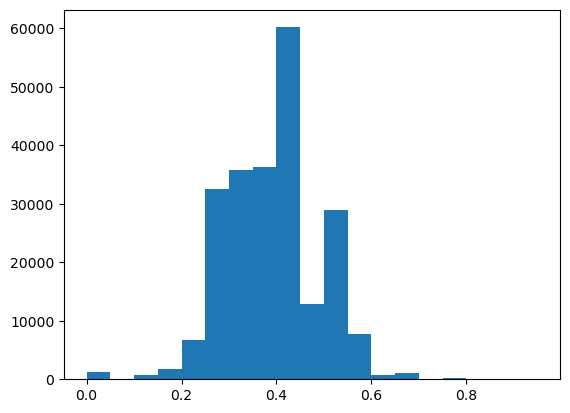

In [8]:
bins = np.arange(0.0, 1.0, 0.05)
plt.hist(x = l, bins = bins)

In [11]:
# From the above plot we can stastically say that if the number of vowels in it are greater than 0.55 times of its lenght than guessing a vowel will not be a good choice.

In [9]:
max_length = 0
for words in df:
    if(len(words)>max_length):
        max_length = len(words)

In [10]:
n_word_dictionary = {i:[] for i in range(3, 30)}
count = 3
while count<=max_length:
    for words in df:
        if(len(words)>=count):
            for i in range(len(words)-count+1):
                #if words[i:i+count-1] not in n_word_dictionary[count]:
                n_word_dictionary[count].append(words[i:i+count]) 
    count = count+1

In [11]:
# function to find number of times a letter come in whole dictionary, keeping count of letter 1 if it comes in a word else 0
def func(new_dictionary):
    dictx = collections.Counter()
    for words in new_dictionary:
        temp = collections.Counter(words)
        for i in temp:
            temp[i] = 1
            dictx = dictx + temp
    return dictx

In [12]:
# function to generate a list of words which are substring in the original dictionary and of same length as clean word
def func2(n_word_dictionary, clean_word):
    new_dictionary = []
    l = len(clean_word)
    for dict_word in n_word_dictionary[l]:
        if re.match(clean_word,dict_word):
            new_dictionary.append(dict_word)
    return new_dictionary

In [13]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)        
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        
        self.current_dictionary = []
        
    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com', 'https://sg.trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link
    
        
    def guess(self, word): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################

        # clean the word so that we strip away the space characters
        # replace "_" with "." as "." indicates any character in regular expressions
        clean_word = word[::2].replace("_",".")
        
        # find length of passed word
        len_word = len(clean_word)
        
        # grab current dictionary of possible words from self object, initialize new possible words dictionary to empty
        current_dictionary = self.current_dictionary
        new_dictionary = []
        
        # iterate through all of the words in the old plausible dictionary
        for dict_word in current_dictionary:
            # continue if the word is not of the appropriate length
            if len(dict_word) != len_word:
                continue
                
            # if dictionary word is a possible match then add it to the current dictionary
            if re.match(clean_word,dict_word):
                new_dictionary.append(dict_word)
        
        # overwrite old possible words dictionary with updated version
        self.current_dictionary = new_dictionary
        
        '''
        # count occurrence of all characters in possible word matches
        full_dict_string = "".join(new_dictionary)
        
        c = collections.Counter(full_dict_string)
        '''
        
        c = func(new_dictionary)
        
        sorted_letter_count = c.most_common()                   
        
        guess_letter = '!'
        
        # return most frequently occurring letter in all possible words that hasn't been guessed yet
        for letter,instance_count in sorted_letter_count:
            if letter not in self.guessed_letters:
                if letter in vowels and vowel_count(clean_word)>0.55:
                    self.guessed_letters.append(letter)
                    continue
                guess_letter = letter
                break
                
        if guess_letter == '!':
            new_dictionary = func2(n_word_dictionary, clean_word)
            c = func(new_dictionary)
            sorted_letter_count = c.most_common()
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in vowels and vowel_count(clean_word)>0.55:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break
                    
                    
        if guess_letter == '!':
            x = int(len(clean_word)/2)
            if x>=3:
                c = collections.Counter()
                for i in range(len(clean_word)-x+1):
                    s = clean_word[i:i+x]
                    new_dictionary = func2(n_word_dictionary, s)
                    temp = func(new_dictionary)
                    c = c+temp
                sorted_letter_count = c.most_common()
                for letter, instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        break
                    
                    
        if guess_letter == '!':
            x = int(len(clean_word)/3)
            if x>=3:
                c = collections.Counter()
                for i in range(len(clean_word)-x+1):
                    s = clean_word[i:i+x]
                    new_dictionary = func2(n_word_dictionary, s)
                    temp = func(new_dictionary)
                    c = c+temp
                sorted_letter_count = c.most_common()
                for letter, instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        break
            
            
        # if no word matches in training dictionary, default back to ordering of full dictionary
        if guess_letter == '!':
            sorted_letter_count = self.full_dictionary_common_letter_sorted
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in vowels and vowel_count(clean_word)>0.55:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break            
        
        return guess_letter

    
    


    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [14]:
api = HangmanAPI(access_token="760895245324f543ffd9306d6d339a", timeout=2000)


## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [ ]:
for i in range(0,50):
    api.start_game(practice=1,verbose=True)
    [total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
    practice_success_rate = total_practice_successes / total_practice_runs
    print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: b8fb1e24f585. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b8fb1e24f585', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b8fb1e24f585', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ i _ _ _ i _ _ _ _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b8fb1e24f585', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ t i _ _ t i _ _ _ _ '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b8fb1e24f585', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ t i _ _ t i _ n _ _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b8fb1e24f585', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ t i _ a t i _ n a _ '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b8fb1e24f585', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ o t i _ a t i o n a _ '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b8fb1e24f585', 'status': 'ongoing', 'tries_remains': 5, 'word': 'm o t i _ a t i o n a _ '}
Guessing letter: v


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b8fb1e24f585', 'status': 'ongoing', 'tries_remains': 5, 'word': 'm o t i v a t i o n a _ '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b8fb1e24f585', 'status': 'success', 'tries_remains': 5, 'word': 'm o t i v a t i o n a l '}
Successfully finished game: b8fb1e24f585


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 156 practice games out of an allotted 100,000. practice success rate so far = 0.154


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: f7bbaaecfbef. # of tries remaining: 6. Word: _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'f7bbaaecfbef', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'f7bbaaecfbef', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ a _ _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'f7bbaaecfbef', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ a r _ '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'f7bbaaecfbef', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ a r _ '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'f7bbaaecfbef', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o _ a r _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'f7bbaaecfbef', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ o _ a r _ '}
Guessing letter: y


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'f7bbaaecfbef', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ o _ a r _ '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'f7bbaaecfbef', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ o _ a r _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'f7bbaaecfbef', 'status': 'failed', 'tries_remains': 0, 'word': '_ o _ a r _ '}
Failed game: f7bbaaecfbef. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 157 practice games out of an allotted 100,000. practice success rate so far = 0.153


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: b204707d4be0. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ _ i _ i _ '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ o _ o _ _ _ _ _ i _ i _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ o _ o _ _ _ _ r i _ i _ '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'ongoing', 'tries_remains': 6, 'word': 'p _ _ _ _ o _ o p _ _ _ r i _ i _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'ongoing', 'tries_remains': 6, 'word': 'p _ _ _ _ o _ o p _ _ _ r i t i _ '}
Guessing letter: h


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'ongoing', 'tries_remains': 5, 'word': 'p _ _ _ _ o _ o p _ _ _ r i t i _ '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'ongoing', 'tries_remains': 5, 'word': 'p _ _ _ _ o _ o p l _ _ r i t i _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'ongoing', 'tries_remains': 5, 'word': 'p _ _ _ _ o _ o p l _ _ r i t i s '}
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'ongoing', 'tries_remains': 5, 'word': 'p _ e _ _ o _ o p l e _ r i t i s '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'ongoing', 'tries_remains': 5, 'word': 'p _ e u _ o _ o p l e u r i t i s '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'ongoing', 'tries_remains': 4, 'word': 'p _ e u _ o _ o p l e u r i t i s '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'ongoing', 'tries_remains': 4, 'word': 'p _ e u m o _ o p l e u r i t i s '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b204707d4be0', 'status': 'success', 'tries_remains': 4, 'word': 'p n e u m o n o p l e u r i t i s '}
Successfully finished game: b204707d4be0


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 158 practice games out of an allotted 100,000. practice success rate so far = 0.158


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 01d167162ad3. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ i _ _ _ _ _ _ '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ i _ _ _ _ _ _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ i _ _ _ _ _ _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ i _ a _ _ _ _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ i _ a t _ _ _ '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ i _ a t o _ _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ r i _ a t o r _ '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'ongoing', 'tries_remains': 3, 'word': 'l _ _ r i _ a t o r _ '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'ongoing', 'tries_remains': 3, 'word': 'l u _ r i _ a t o r _ '}
Guessing letter: b


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'ongoing', 'tries_remains': 3, 'word': 'l u b r i _ a t o r _ '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'ongoing', 'tries_remains': 3, 'word': 'l u b r i c a t o r _ '}
Guessing letter: y


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '01d167162ad3', 'status': 'success', 'tries_remains': 3, 'word': 'l u b r i c a t o r y '}
Successfully finished game: 01d167162ad3


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 159 practice games out of an allotted 100,000. practice success rate so far = 0.164


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: a6075ab62195. # of tries remaining: 6. Word: _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'a6075ab62195', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'a6075ab62195', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ e _ _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'a6075ab62195', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ e _ r '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'a6075ab62195', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ e a r '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'a6075ab62195', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ o _ _ e a r '}
Guessing letter: f


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'a6075ab62195', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o _ _ e a r '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'a6075ab62195', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o _ c e a r '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'a6075ab62195', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ o n c e a r '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'a6075ab62195', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ o n c e a r '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'a6075ab62195', 'status': 'success', 'tries_remains': 3, 'word': 'm o n c e a r '}
Successfully finished game: a6075ab62195


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 160 practice games out of an allotted 100,000. practice success rate so far = 0.169


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 87d07a2921a2. # of tries remaining: 6. Word: _ _ _ _ _ .
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '87d07a2921a2', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ '}
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '87d07a2921a2', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ _ _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '87d07a2921a2', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ r _ '}
Guessing letter: y


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '87d07a2921a2', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ e _ r _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '87d07a2921a2', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ e _ r _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '87d07a2921a2', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ e _ r _ '}
Guessing letter: b


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '87d07a2921a2', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ e _ r _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '87d07a2921a2', 'status': 'failed', 'tries_remains': 0, 'word': '_ e _ r _ '}
Failed game: 87d07a2921a2. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 161 practice games out of an allotted 100,000. practice success rate so far = 0.168


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 265124454736. # of tries remaining: 6. Word: _ _ _ .
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '265124454736', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '265124454736', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ s _ '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '265124454736', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ s _ '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '265124454736', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ s _ '}
Guessing letter: b


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '265124454736', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ s _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '265124454736', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ s _ '}
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '265124454736', 'status': 'failed', 'tries_remains': 0, 'word': '_ s _ '}
Failed game: 265124454736. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 162 practice games out of an allotted 100,000. practice success rate so far = 0.167


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 397af32e8a5b. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '397af32e8a5b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e _ _ _ _ _ _ _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '397af32e8a5b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ e _ _ _ _ _ _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '397af32e8a5b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ e _ _ _ _ i _ _ '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '397af32e8a5b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ e _ _ _ n i _ n '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '397af32e8a5b', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ _ e _ _ a n i a n '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '397af32e8a5b', 'status': 'ongoing', 'tries_remains': 4, 'word': 'a _ _ e _ _ a n i a n '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '397af32e8a5b', 'status': 'ongoing', 'tries_remains': 3, 'word': 'a _ _ e _ _ a n i a n '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '397af32e8a5b', 'status': 'ongoing', 'tries_remains': 3, 'word': 'a l l e _ _ a n i a n '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '397af32e8a5b', 'status': 'ongoing', 'tries_remains': 2, 'word': 'a l l e _ _ a n i a n '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '397af32e8a5b', 'status': 'ongoing', 'tries_remains': 1, 'word': 'a l l e _ _ a n i a n '}
Guessing letter: h


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '397af32e8a5b', 'status': 'ongoing', 'tries_remains': 1, 'word': 'a l l e _ h a n i a n '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '397af32e8a5b', 'status': 'failed', 'tries_remains': 0, 'word': 'a l l e _ h a n i a n '}
Failed game: 397af32e8a5b. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 163 practice games out of an allotted 100,000. practice success rate so far = 0.166


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 31dc5a6205f4. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31dc5a6205f4', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31dc5a6205f4', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ i _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31dc5a6205f4', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ a _ _ i _ '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31dc5a6205f4', 'status': 'ongoing', 'tries_remains': 5, 'word': 'c _ _ _ a _ _ i _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31dc5a6205f4', 'status': 'ongoing', 'tries_remains': 5, 'word': 'c r _ _ a _ _ i _ '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31dc5a6205f4', 'status': 'ongoing', 'tries_remains': 5, 'word': 'c r o _ a _ o i _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31dc5a6205f4', 'status': 'ongoing', 'tries_remains': 5, 'word': 'c r o t a _ o i _ '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31dc5a6205f4', 'status': 'ongoing', 'tries_remains': 5, 'word': 'c r o t a _ o i d '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31dc5a6205f4', 'status': 'success', 'tries_remains': 5, 'word': 'c r o t a l o i d '}
Successfully finished game: 31dc5a6205f4


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 164 practice games out of an allotted 100,000. practice success rate so far = 0.171


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 289b332b34e8. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ i _ _ '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ n _ i n _ '}
Guessing letter: g


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ n _ i n g '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ n _ i n g '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ n _ i n g '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ u n _ i n g '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ o _ o u n _ i n g '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'ongoing', 'tries_remains': 3, 'word': 'c o _ o u n _ i n g '}
Guessing letter: f


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'ongoing', 'tries_remains': 2, 'word': 'c o _ o u n _ i n g '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'ongoing', 'tries_remains': 2, 'word': 'c o _ o u n d i n g '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'ongoing', 'tries_remains': 1, 'word': 'c o _ o u n d i n g '}
Guessing letter: b


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '289b332b34e8', 'status': 'failed', 'tries_remains': 0, 'word': 'c o _ o u n d i n g '}
Failed game: 289b332b34e8. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 165 practice games out of an allotted 100,000. practice success rate so far = 0.170


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 9a15dfdc20e8. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9a15dfdc20e8', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ _ _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9a15dfdc20e8', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ i _ i _ _ _ _ '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9a15dfdc20e8', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ i n i _ _ _ _ '}
Guessing letter: f


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9a15dfdc20e8', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ i n i f _ _ _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9a15dfdc20e8', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ i n i f _ r _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9a15dfdc20e8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ i n i f _ r _ '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9a15dfdc20e8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ i n i f o r _ '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9a15dfdc20e8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e m i n i f o r m '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9a15dfdc20e8', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ e m i n i f o r m '}
Guessing letter: g


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9a15dfdc20e8', 'status': 'success', 'tries_remains': 4, 'word': 'g e m i n i f o r m '}
Successfully finished game: 9a15dfdc20e8


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 166 practice games out of an allotted 100,000. practice success rate so far = 0.175


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 2e35279719a8. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2e35279719a8', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e _ _ _ _ _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2e35279719a8', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ r _ e r r _ _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2e35279719a8', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ r i e r r _ _ _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2e35279719a8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ r i e r r _ _ _ '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2e35279719a8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ r i e r r o o _ '}
Guessing letter: f


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2e35279719a8', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ r i e r r o o _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2e35279719a8', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ r i e r r o o t '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2e35279719a8', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ r i e r r o o t '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2e35279719a8', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ r i e r r o o t '}
Guessing letter: b


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2e35279719a8', 'status': 'success', 'tries_remains': 2, 'word': 'b r i e r r o o t '}
Successfully finished game: 2e35279719a8


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 167 practice games out of an allotted 100,000. practice success rate so far = 0.180


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 7fd4da7648ea. # of tries remaining: 6. Word: _ _ _ .
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7fd4da7648ea', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7fd4da7648ea', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ s _ '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7fd4da7648ea', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ s _ '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7fd4da7648ea', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ s _ '}
Guessing letter: b


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7fd4da7648ea', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ s _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7fd4da7648ea', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ s _ '}
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7fd4da7648ea', 'status': 'ongoing', 'tries_remains': 1, 'word': 'e s _ '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7fd4da7648ea', 'status': 'failed', 'tries_remains': 0, 'word': 'e s _ '}
Failed game: 7fd4da7648ea. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 168 practice games out of an allotted 100,000. practice success rate so far = 0.179


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 2b4441153388. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2b4441153388', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ e '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2b4441153388', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ a _ _ _ e '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2b4441153388', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ a _ i _ e '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2b4441153388', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ t a t i _ e '}
Guessing letter: v


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2b4441153388', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ t a t i v e '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2b4441153388', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ t a t i v e '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2b4441153388', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ t a t i v e '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2b4441153388', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ t a t i v e '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2b4441153388', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ u t a t i v e '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '2b4441153388', 'status': 'success', 'tries_remains': 3, 'word': 'm u t a t i v e '}
Successfully finished game: 2b4441153388


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 169 practice games out of an allotted 100,000. practice success rate so far = 0.183


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: affc2bcd071b. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'affc2bcd071b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ i _ _ _ _ i _ i _ _ _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'affc2bcd071b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ s i _ _ _ _ i _ i _ _ _ '}
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'affc2bcd071b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ s i _ e _ _ i _ i _ _ _ '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'affc2bcd071b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ s i _ e _ l i _ i _ l _ '}
Guessing letter: g


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'affc2bcd071b', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ s i _ e g l i g i _ l _ '}
Guessing letter: q


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'affc2bcd071b', 'status': 'ongoing', 'tries_remains': 6, 'word': 'q _ _ s i _ e g l i g i _ l _ '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'affc2bcd071b', 'status': 'ongoing', 'tries_remains': 6, 'word': 'q u _ s i _ e g l i g i _ l _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'affc2bcd071b', 'status': 'ongoing', 'tries_remains': 6, 'word': 'q u a s i _ e g l i g i _ l _ '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'affc2bcd071b', 'status': 'ongoing', 'tries_remains': 6, 'word': 'q u a s i n e g l i g i _ l _ '}
Guessing letter: b


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'affc2bcd071b', 'status': 'ongoing', 'tries_remains': 6, 'word': 'q u a s i n e g l i g i b l _ '}
Guessing letter: y


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'affc2bcd071b', 'status': 'success', 'tries_remains': 6, 'word': 'q u a s i n e g l i g i b l y '}
Successfully finished game: affc2bcd071b


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 170 practice games out of an allotted 100,000. practice success rate so far = 0.188


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 25de1c6d6018. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e _ _ _ e '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ e _ _ _ e '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ e _ _ _ e '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ e _ _ _ e '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ e _ i _ e '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ e l i _ e '}
Guessing letter: k


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ e l i k e '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ _ _ _ e l i k e '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'ongoing', 'tries_remains': 2, 'word': 'u _ _ u _ _ e l i k e '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'ongoing', 'tries_remains': 2, 'word': 'u n _ u n _ e l i k e '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'ongoing', 'tries_remains': 1, 'word': 'u n _ u n _ e l i k e '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'ongoing', 'tries_remains': 1, 'word': 'u n d u n _ e l i k e '}
Guessing letter: g


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '25de1c6d6018', 'status': 'failed', 'tries_remains': 0, 'word': 'u n d u n _ e l i k e '}
Failed game: 25de1c6d6018. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 171 practice games out of an allotted 100,000. practice success rate so far = 0.187


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 6474de4079e7. # of tries remaining: 6. Word: _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '6474de4079e7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '6474de4079e7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ a _ _ _ _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '6474de4079e7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ a r _ _ _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '6474de4079e7', 'status': 'ongoing', 'tries_remains': 5, 'word': 's _ a r _ s _ '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '6474de4079e7', 'status': 'ongoing', 'tries_remains': 4, 'word': 's _ a r _ s _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '6474de4079e7', 'status': 'ongoing', 'tries_remains': 4, 'word': 's t a r _ s t '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '6474de4079e7', 'status': 'success', 'tries_remains': 4, 'word': 's t a r o s t '}
Successfully finished game: 6474de4079e7


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 172 practice games out of an allotted 100,000. practice success rate so far = 0.192


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 31a89386ef2b. # of tries remaining: 6. Word: _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31a89386ef2b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31a89386ef2b', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31a89386ef2b', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31a89386ef2b', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ _ _ _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31a89386ef2b', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ _ _ s '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31a89386ef2b', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ o o _ _ s '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31a89386ef2b', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ o o _ _ s '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '31a89386ef2b', 'status': 'failed', 'tries_remains': 0, 'word': '_ o o _ _ s '}
Failed game: 31a89386ef2b. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 173 practice games out of an allotted 100,000. practice success rate so far = 0.191


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: ebc6105e0920. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ _ e _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ r _ _ _ _ _ e _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ r _ _ _ a _ e _ '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ r _ _ _ a _ e d '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ r _ _ _ a t e d '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ o r _ _ _ a t e d '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ o r _ _ _ a t e d '}
Guessing letter: f


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'ongoing', 'tries_remains': 5, 'word': 'f o r _ _ _ a t e d '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'ongoing', 'tries_remains': 4, 'word': 'f o r _ _ _ a t e d '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'ongoing', 'tries_remains': 4, 'word': 'f o r m _ _ a t e d '}
Guessing letter: y


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'ongoing', 'tries_remains': 3, 'word': 'f o r m _ _ a t e d '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'ongoing', 'tries_remains': 3, 'word': 'f o r m _ l a t e d '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'ebc6105e0920', 'status': 'success', 'tries_remains': 3, 'word': 'f o r m u l a t e d '}
Successfully finished game: ebc6105e0920


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 174 practice games out of an allotted 100,000. practice success rate so far = 0.195


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 8b4b9bd56b02. # of tries remaining: 6. Word: _ _ _ _ .
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8b4b9bd56b02', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ '}
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8b4b9bd56b02', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ e _ _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8b4b9bd56b02', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r e _ _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8b4b9bd56b02', 'status': 'ongoing', 'tries_remains': 4, 'word': 'r e _ _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8b4b9bd56b02', 'status': 'ongoing', 'tries_remains': 3, 'word': 'r e _ _ '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8b4b9bd56b02', 'status': 'ongoing', 'tries_remains': 2, 'word': 'r e _ _ '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8b4b9bd56b02', 'status': 'ongoing', 'tries_remains': 1, 'word': 'r e _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8b4b9bd56b02', 'status': 'failed', 'tries_remains': 0, 'word': 'r e _ _ '}
Failed game: 8b4b9bd56b02. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 175 practice games out of an allotted 100,000. practice success rate so far = 0.194


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 8f63721544ae. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ _ _ _ _ _ _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ a _ a _ _ _ _ '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ a n a _ _ _ _ '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'ongoing', 'tries_remains': 4, 'word': 'c _ _ _ _ _ a n a _ _ _ _ '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'ongoing', 'tries_remains': 4, 'word': 'c _ _ _ _ o a n a _ _ _ _ '}
Guessing letter: h


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'ongoing', 'tries_remains': 3, 'word': 'c _ _ _ _ o a n a _ _ _ _ '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'ongoing', 'tries_remains': 3, 'word': 'c _ _ _ _ o a n a l _ _ _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'ongoing', 'tries_remains': 3, 'word': 'c _ _ _ t o a n a l _ _ t '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'ongoing', 'tries_remains': 3, 'word': 'c r _ _ t o a n a l _ _ t '}
Guessing letter: y


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'ongoing', 'tries_remains': 3, 'word': 'c r y _ t o a n a l y _ t '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'ongoing', 'tries_remains': 3, 'word': 'c r y p t o a n a l y _ t '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8f63721544ae', 'status': 'success', 'tries_remains': 3, 'word': 'c r y p t o a n a l y s t '}
Successfully finished game: 8f63721544ae


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 176 practice games out of an allotted 100,000. practice success rate so far = 0.199


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 800c0f2a0e96. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '800c0f2a0e96', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ _ e _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '800c0f2a0e96', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ r _ e r r e _ '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '800c0f2a0e96', 'status': 'ongoing', 'tries_remains': 6, 'word': 'p _ r _ e r r e _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '800c0f2a0e96', 'status': 'ongoing', 'tries_remains': 6, 'word': 'p a r _ e r r e _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '800c0f2a0e96', 'status': 'ongoing', 'tries_remains': 6, 'word': 'p a r t e r r e _ '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '800c0f2a0e96', 'status': 'ongoing', 'tries_remains': 5, 'word': 'p a r t e r r e _ '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '800c0f2a0e96', 'status': 'ongoing', 'tries_remains': 4, 'word': 'p a r t e r r e _ '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '800c0f2a0e96', 'status': 'ongoing', 'tries_remains': 3, 'word': 'p a r t e r r e _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '800c0f2a0e96', 'status': 'success', 'tries_remains': 3, 'word': 'p a r t e r r e s '}
Successfully finished game: 800c0f2a0e96


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 177 practice games out of an allotted 100,000. practice success rate so far = 0.203


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 502633045c4d. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '502633045c4d', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '502633045c4d', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e r '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '502633045c4d', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ e r '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '502633045c4d', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ e r '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '502633045c4d', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ e r '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '502633045c4d', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ _ _ _ e r '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '502633045c4d', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ _ _ _ _ _ e r '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '502633045c4d', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ n _ _ _ _ e r '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '502633045c4d', 'status': 'ongoing', 'tries_remains': 1, 'word': 'u n _ u _ _ e r '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '502633045c4d', 'status': 'ongoing', 'tries_remains': 1, 'word': 'u n _ u c _ e r '}
Guessing letter: k


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '502633045c4d', 'status': 'ongoing', 'tries_remains': 1, 'word': 'u n _ u c k e r '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '502633045c4d', 'status': 'success', 'tries_remains': 1, 'word': 'u n p u c k e r '}
Successfully finished game: 502633045c4d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 178 practice games out of an allotted 100,000. practice success rate so far = 0.208


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 0acce9637eb8. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '0acce9637eb8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '0acce9637eb8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ a _ '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '0acce9637eb8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ n _ a _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '0acce9637eb8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ i n _ a _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '0acce9637eb8', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ r i n _ a _ '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '0acce9637eb8', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ r i n _ a _ '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '0acce9637eb8', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ r i n _ a _ '}
Guessing letter: g


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '0acce9637eb8', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ r i n g a _ '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '0acce9637eb8', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ r i n g a _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '0acce9637eb8', 'status': 'ongoing', 'tries_remains': 2, 'word': 's _ r i n g a s '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '0acce9637eb8', 'status': 'ongoing', 'tries_remains': 1, 'word': 's _ r i n g a s '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '0acce9637eb8', 'status': 'failed', 'tries_remains': 0, 'word': 's _ r i n g a s '}
Failed game: 0acce9637eb8. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 179 practice games out of an allotted 100,000. practice success rate so far = 0.207


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 9fbdacc6b3a7. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9fbdacc6b3a7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9fbdacc6b3a7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ a _ _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9fbdacc6b3a7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ a r _ '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9fbdacc6b3a7', 'status': 'ongoing', 'tries_remains': 5, 'word': 'd _ _ _ _ a r _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9fbdacc6b3a7', 'status': 'ongoing', 'tries_remains': 4, 'word': 'd _ _ _ _ a r _ '}
Guessing letter: y


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9fbdacc6b3a7', 'status': 'ongoing', 'tries_remains': 3, 'word': 'd _ _ _ _ a r _ '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9fbdacc6b3a7', 'status': 'ongoing', 'tries_remains': 2, 'word': 'd _ _ _ _ a r _ '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9fbdacc6b3a7', 'status': 'ongoing', 'tries_remains': 2, 'word': 'd _ _ _ _ a r m '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9fbdacc6b3a7', 'status': 'ongoing', 'tries_remains': 2, 'word': 'd i _ _ _ a r m '}
Guessing letter: f


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9fbdacc6b3a7', 'status': 'ongoing', 'tries_remains': 1, 'word': 'd i _ _ _ a r m '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '9fbdacc6b3a7', 'status': 'failed', 'tries_remains': 0, 'word': 'd i _ _ _ a r m '}
Failed game: 9fbdacc6b3a7. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 180 practice games out of an allotted 100,000. practice success rate so far = 0.206


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 3e7b570b887b. # of tries remaining: 6. Word: _ _ _ _ .
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '3e7b570b887b', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ '}
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '3e7b570b887b', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '3e7b570b887b', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '3e7b570b887b', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ s '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '3e7b570b887b', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ i _ s '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '3e7b570b887b', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ i _ s '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '3e7b570b887b', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ i _ s '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '3e7b570b887b', 'status': 'failed', 'tries_remains': 0, 'word': '_ i _ s '}
Failed game: 3e7b570b887b. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 181 practice games out of an allotted 100,000. practice success rate so far = 0.204


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 8589974654f7. # of tries remaining: 6. Word: _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8589974654f7', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8589974654f7', 'status': 'ongoing', 'tries_remains': 5, 'word': 'a _ _ _ a _ '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8589974654f7', 'status': 'ongoing', 'tries_remains': 4, 'word': 'a _ _ _ a _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8589974654f7', 'status': 'ongoing', 'tries_remains': 3, 'word': 'a _ _ _ a _ '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8589974654f7', 'status': 'ongoing', 'tries_remains': 2, 'word': 'a _ _ _ a _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8589974654f7', 'status': 'ongoing', 'tries_remains': 1, 'word': 'a _ _ _ a _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8589974654f7', 'status': 'ongoing', 'tries_remains': 1, 'word': 'a _ i _ a _ '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '8589974654f7', 'status': 'failed', 'tries_remains': 0, 'word': 'a _ i _ a _ '}
Failed game: 8589974654f7. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 182 practice games out of an allotted 100,000. practice success rate so far = 0.203


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 7d620461f77c. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7d620461f77c', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ _ _ _ _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7d620461f77c', 'status': 'ongoing', 'tries_remains': 6, 'word': 'r _ _ _ _ e _ _ _ _ _ '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7d620461f77c', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r _ _ _ _ e _ _ _ _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7d620461f77c', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r _ _ _ _ e _ _ i _ _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7d620461f77c', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r _ _ s s e _ _ i s _ '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7d620461f77c', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r _ u s s e _ u i s _ '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7d620461f77c', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r o u s s e _ u i s _ '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7d620461f77c', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r o u s s e a u i s _ '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7d620461f77c', 'status': 'ongoing', 'tries_remains': 4, 'word': 'r o u s s e a u i s _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '7d620461f77c', 'status': 'success', 'tries_remains': 4, 'word': 'r o u s s e a u i s t '}
Successfully finished game: 7d620461f77c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 183 practice games out of an allotted 100,000. practice success rate so far = 0.208


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 46272c4f48dc. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ _ _ _ e _ e _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ _ _ _ e r e _ '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ e _ _ _ _ e r e d '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 6, 'word': 't _ _ _ e _ _ _ _ e r e d '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 6, 'word': 't _ i _ e _ _ _ _ e r e d '}
Guessing letter: w


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 6, 'word': 't w i _ e _ _ _ _ e r e d '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 6, 'word': 't w i c e _ _ _ _ e r e d '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 5, 'word': 't w i c e _ _ _ _ e r e d '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 5, 'word': 't w i c e _ u _ _ e r e d '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 4, 'word': 't w i c e _ u _ _ e r e d '}
Guessing letter: b


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 3, 'word': 't w i c e _ u _ _ e r e d '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 2, 'word': 't w i c e _ u _ _ e r e d '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 1, 'word': 't w i c e _ u _ _ e r e d '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'ongoing', 'tries_remains': 1, 'word': 't w i c e s u _ _ e r e d '}
Guessing letter: v


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '46272c4f48dc', 'status': 'failed', 'tries_remains': 0, 'word': 't w i c e s u _ _ e r e d '}
Failed game: 46272c4f48dc. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 184 practice games out of an allotted 100,000. practice success rate so far = 0.207


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 02e24e8f6a7d. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '02e24e8f6a7d', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ _ _ _ _ _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '02e24e8f6a7d', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ _ _ _ _ i _ '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '02e24e8f6a7d', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ c _ _ _ i c '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '02e24e8f6a7d', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ c _ _ r i c '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '02e24e8f6a7d', 'status': 'ongoing', 'tries_remains': 5, 'word': 'e _ c _ _ r i c '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '02e24e8f6a7d', 'status': 'ongoing', 'tries_remains': 5, 'word': 'e _ c _ o r i c '}
Guessing letter: h


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '02e24e8f6a7d', 'status': 'ongoing', 'tries_remains': 5, 'word': 'e _ c h o r i c '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '02e24e8f6a7d', 'status': 'success', 'tries_remains': 5, 'word': 'e n c h o r i c '}
Successfully finished game: 02e24e8f6a7d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 185 practice games out of an allotted 100,000. practice success rate so far = 0.211


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 4ce77d79aada. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '4ce77d79aada', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e _ _ _ _ _ _ e _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '4ce77d79aada', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ e _ _ _ r _ _ e _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '4ce77d79aada', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ i _ e _ _ i r i _ e _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '4ce77d79aada', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ i _ e s _ i r i _ e _ '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '4ce77d79aada', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ i _ e s p i r i _ e _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '4ce77d79aada', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ i _ e s p i r i t e _ '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '4ce77d79aada', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ i _ e s p i r i t e d '}
Guessing letter: v


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '4ce77d79aada', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ i _ e s p i r i t e d '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '4ce77d79aada', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ i _ e s p i r i t e d '}
Guessing letter: f


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '4ce77d79aada', 'status': 'ongoing', 'tries_remains': 4, 'word': 'f i _ e s p i r i t e d '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '4ce77d79aada', 'status': 'ongoing', 'tries_remains': 3, 'word': 'f i _ e s p i r i t e d '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '4ce77d79aada', 'status': 'success', 'tries_remains': 3, 'word': 'f i n e s p i r i t e d '}
Successfully finished game: 4ce77d79aada


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 186 practice games out of an allotted 100,000. practice success rate so far = 0.215


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: fa447853becc. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'fa447853becc', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ e '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'fa447853becc', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ a _ _ _ _ _ e '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'fa447853becc', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ _ _ _ _ e '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'fa447853becc', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ _ l _ _ e '}
Guessing letter: k


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'fa447853becc', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ a _ _ l _ _ e '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'fa447853becc', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ a _ _ l _ _ e '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'fa447853becc', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ a _ _ l _ _ e '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'fa447853becc', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ a _ c l _ _ e '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'fa447853becc', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ a _ c l _ _ e '}
Guessing letter: v


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'fa447853becc', 'status': 'failed', 'tries_remains': 0, 'word': '_ a _ c l _ _ e '}
Failed game: fa447853becc. Because of: # of tries exceeded!


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 187 practice games out of an allotted 100,000. practice success rate so far = 0.214


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: b73ddbbaa028. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ e _ '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ e _ '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ e s '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ e s '}
Guessing letter: a


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ a _ _ _ _ e s '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ a _ _ _ _ e s '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ a _ _ _ l e s '}
Guessing letter: c


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ a _ _ _ l e s '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ a _ _ o l e s '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ a _ p o l e s '}
Guessing letter: m


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'ongoing', 'tries_remains': 2, 'word': 'm a _ p o l e s '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'ongoing', 'tries_remains': 1, 'word': 'm a _ p o l e s '}
Guessing letter: y


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b73ddbbaa028', 'status': 'success', 'tries_remains': 1, 'word': 'm a y p o l e s '}
Successfully finished game: b73ddbbaa028


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 188 practice games out of an allotted 100,000. practice success rate so far = 0.218


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: b265bcef4e53. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b265bcef4e53', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ _ _ _ e '}
Guessing letter: r


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b265bcef4e53', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e _ _ _ _ _ r e '}
Guessing letter: u


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b265bcef4e53', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e u _ _ _ _ r e '}
Guessing letter: o


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b265bcef4e53', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ e u _ o _ o r e '}
Guessing letter: n


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b265bcef4e53', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ e u _ o _ o r e '}
Guessing letter: p


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b265bcef4e53', 'status': 'ongoing', 'tries_remains': 5, 'word': 'p _ e u _ o p o r e '}
Guessing letter: d


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b265bcef4e53', 'status': 'ongoing', 'tries_remains': 5, 'word': 'p _ e u d o p o r e '}
Guessing letter: s


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': 'b265bcef4e53', 'status': 'success', 'tries_remains': 5, 'word': 'p s e u d o p o r e '}
Successfully finished game: b265bcef4e53


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


run 189 practice games out of an allotted 100,000. practice success rate so far = 0.222


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Successfully start a new game! Game ID: 86d0344fb1ed. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '86d0344fb1ed', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ _ _ _ _ _ _ _ e _ _ '}
Guessing letter: t


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '86d0344fb1ed', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ _ _ _ _ t _ _ e _ _ '}
Guessing letter: i


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '86d0344fb1ed', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ _ i _ i t i _ e _ _ '}
Guessing letter: l


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '86d0344fb1ed', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ _ i _ i t i _ e l _ '}
Guessing letter: b


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '86d0344fb1ed', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ _ i b i t i _ e l _ '}
Guessing letter: v


/Users/tanmay/anaconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sg.trexsim.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Sever response: {'game_id': '86d0344fb1ed', 'status': 'ongoing', 'tries_remains': 6, 'word': 'e _ _ i b i t i v e l _ '}


## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [21]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Playing  1  th game
Playing  2  th game
Playing  3  th game
Playing  4  th game
Playing  5  th game
Playing  6  th game
Playing  7  th game
Playing  8  th game
Playing  9  th game
Playing  10  th game
Playing  11  th game
Playing  12  th game
Playing  13  th game
Playing  14  th game
Playing  15  th game
Playing  16  th game
Playing  17  th game
Playing  18  th game
Playing  19  th game
Playing  20  th game
Playing  21  th game
Playing  22  th game
Playing  23  th game
Playing  24  th game
Playing  25  th game
Playing  26  th game
Playing  27  th game
Playing  28  th game
Playing  29  th game
Playing  30  th game
Playing  31  th game
Playing  32  th game
Playing  33  th game
Playing  34  th game
Playing  35  th game
Playing  36  th game
Playing  37  th game
Playing  38  th game
Playing  39  th game
Playing  40  th game
Playing  41  th game
Playing  42  th game
Playing  43  th game
Playing  44  th game
Playing  45  th game
Playing  46  th game
Playing  47  th game
Pl

HangmanAPIError: {'error': 'You have reached 1000 of games', 'status': 'denied'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [22]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.553
